In [1]:
%matplotlib inline

In [33]:
from __future__ import print_function, division
import os, sys, time
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib
from sklearn import manifold, ensemble
from sklearn import svm
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

In [3]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2

In [4]:
import pywt

In [5]:
from imp import reload
import glob

In [6]:
# os.chdir('..')
os.chdir('/home/mm/py/kaggle/')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics
from eegkaggle.models import neural
from keras.utils import np_utils
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, Dropout, GaussianNoise, GaussianDropout, Activation
from keras.models import Model, Sequential

/home/mm/py/kaggle


Using TensorFlow backend.


In [7]:
print(matplotlib.style.available)
matplotlib.style.use('dark_background')
colors = ['k', 'r', 'g', 'b', 'm', 'y', 'c']

['seaborn-bright', 'grayscale', 'seaborn-poster', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-whitegrid', 'dark_background', 'seaborn-deep', 'seaborn-white', 'fivethirtyeight', 'seaborn-paper', 'seaborn-pastel', 'seaborn-dark', 'seaborn-muted', 'ggplot', 'seaborn-colorblind', 'seaborn-notebook', 'seaborn-darkgrid', 'classic', 'bmh', 'seaborn-ticks']


In [8]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

In [9]:
def intn(val):
    try:
        return int(val)
    except ValueError:
        return -1

def scatter_heat(sorted_data, class_cut, rad=200, alpha=0.2):
    plt.scatter(sorted_data[:class_cut, 0], sorted_data[:class_cut, 1], edgecolor='none', c='b', s=3)
    plt.scatter(sorted_data[class_cut:, 0], sorted_data[class_cut:, 1], edgecolor='none', c='orange', s=rad, alpha=alpha )
    plt.scatter(sorted_data[class_cut:, 0], sorted_data[class_cut:, 1], edgecolor='none', c='r', s=5 )
    
def zdiff(d0, d1):
    fullds = np.concatenate([d0, d1], axis=0)
    mean = np.mean(fullds, axis=0)
    mean0 = np.mean(d0, axis=0)
    mean1 = np.mean(d1, axis=0)
    std = np.std(fullds, axis=0)
    return(mean1-mean0)/std
    
def zdiff_by_channel(d0, d1, nchan=16):
    # Interleaved
    zdf = zdiff(d0, d1) 
    chans = []
    for i in range(nchan):
        chans.append(zdf[i::nchan])
    return np.array(chans)

def extract_patient_set(x_data, y_data, df, patient_num, col='patient'):
    mask = df[col] == patient_num
    select_df = df[mask]
    nb_records = sum(mask)
    vec_shape = x_data.shape[1:]
    new_x = np.zeros((nb_records,) + vec_shape )
    new_y = np.zeros((nb_records,) + y_data.shape[1:] )

    for i in range(nb_records):
        new_x[i] = x_data[select_df.index[i]]
        new_y[i] = y_data[select_df.index[i]]
    return new_x, new_y, select_df

In [40]:
reload(dataio)
guess_path = '/run/media/mike/Elements/data/kaggle/melbourne/test_new/vec_logfourier_0343_238_0'
# guess_path = '/run/media/mike/Elements/data/kaggle/melbourne/test_new/vec_metric_pow_0283_468_0'
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_logfourier_0314_411_0'
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_logfourier_0470_618_0' # hilbert envelope
train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_ftfc_0349_416_0' # ftfc
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_ftfc_0484_806_0' # ftfc w/ hilbert envelope
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_metric_pow_0275_890_0'
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_fftsplit_0397_555_0' # so large
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_simple_metric_0433_218_0' # with hilbert envelope
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/train_all/vec_metric_pow_0485_697_0' # with hilbert envelope
# train_path = '/run/media/mike/Elements/data/kaggle/melbourne/vectors/vec_sampen_1479009141' # which one is this?
train_path = '/media/mm/B3AE-826D/kaggle/vec_simple_1479057070' # good separation on first dim
train_path = '/media/mm/B3AE-826D/kaggle/vec_sampen_1478971675' # sampen with good separation
# alt_path = '/media/mm/B3AE-826D/kaggle/vec_simple_1479057070'
x_train, y_train = dataio.reload_with_labels(train_path)
if y_train is None:
    y_train = dataio.load_label_ary(alt_path)
# x_guess, y_guess = dataio.reload_with_labels(guess_path)
x_guess = dt
print(x_train.shape, y_train.shape)

files_train = pd.read_csv(train_path + '_name.csv', index_col=0) 
files_guess = pd.read_csv(train_path + '_name.csv', index_col=0) 
print(x_train.shape, files_train.shape,  y_train.shape, files_guess.shape)

files_train['File'] = pd.Series([os.path.basename(nm) for nm in files_train['path']])
files_train['patient'] = pd.Series([intn(nm[0]) or -1 for nm in files_train['File']])
files_train['label'] = pd.Series([intn(nm[-5]) for nm in files_train['File']])
files_train.head()

x_train1, y_train1, df1 = extract_patient_set(x_train, y_train, files_train, 1)
x_train2, y_train2, df2 = extract_patient_set(x_train, y_train, files_train, 2)
x_train3, y_train3, df3 = extract_patient_set(x_train, y_train, files_train, 3)

print(x_train1.shape, y_train1.shape, df1.shape)
print(x_train2.shape, y_train2.shape, df2.shape)
print(x_train3.shape, y_train3.shape, df3.shape)


print(len(files_train[files_train['patient'] == 1]))
print(len(files_train[files_train['patient'] == 2]))
print(len(files_train[files_train['patient'] == 3]))

print(np.mean(files_train[files_train['patient'] == 1]['label'], axis=0))
print(np.mean(files_train[files_train['patient'] == 2]['label'], axis=0))
print(np.mean(files_train[files_train['patient'] == 3]['label'], axis=0))
print(np.mean(files_train['label'], axis=0))

(3084, 112) (3084, 1)
(3084, 112) (3084, 1) (3084, 1) (3084, 1)
(0, 112) (0, 1) (0, 4)
(0, 112) (0, 1) (0, 4)
(2394, 112) (2394, 1) (2394, 4)
0
0
2394
nan
nan
0.062656641604
1.05544747082


In [41]:
y_train.ndim

2

(2244, 112) (150, 112) (690, 112)


/home/mm/py/ml/tf/local/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in subtract
/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


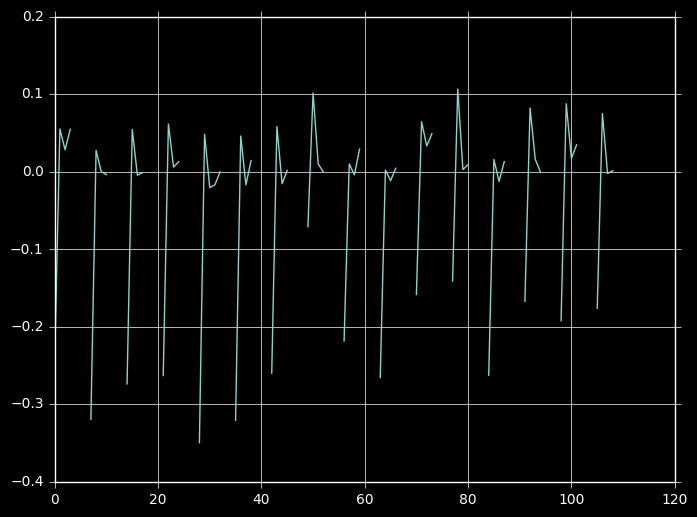

In [42]:
d0, d1, dt = dataio.separate_sets(x_train, y_train)
print(d0.shape, d1.shape, dt.shape)
auc1 = zdiff_by_channel(d0, d1)
plt.plot(zdiff(d0, d1))

In [43]:
# d0, d1, dt = dataio.separate_sets(x_train1, y_train1)
# auc1 = zdiff_by_channel(d0, d1)
# plt.plot(zdiff(d0, d1))
# d0, d1, dt = dataio.separate_sets(x_train2, y_train2)
# auc2 = zdiff_by_channel(d0, d1)
# plt.plot(zdiff(d0, d1))
# d0, d1, dt = dataio.separate_sets(x_train3, y_train3)
# auc3 = zdiff_by_channel(d0, d1)
# plt.plot(zdiff(d0, d1))
# print(auc1.shape, auc2.shape, auc3.shape)

In [45]:
mean0 = np.mean(d0, axis=0)
mean1 = np.mean(d1, axis=0)
std0 = np.std(d0, axis=0)
std1 = np.std(d1, axis=0)

/home/mm/py/ml/tf/local/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [60]:
len(d0), len(d1)


In [61]:
X, Y = x_train, y_train
Y = np.concatenate([np.zeros(len(d0)).reshape(-1,1), np.ones(len(d1)).reshape(-1,1)], axis=0)
x_mean = np.mean(X, axis=0)
x_std = np.std(X, axis=0)
x_train_z = (X - x_mean) / x_std
y_train_z = Y
x_guess_z = (x_guess - x_mean) / x_std
d0_z = (d0 - x_mean) / x_std
d1_z = (d1 - x_mean) / x_std

/home/mm/py/ml/tf/local/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in true_divide
/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in true_divide
/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


In [66]:
x_train_s = np.concatenate([d0_z, d1_z], axis=0)
x_mean = np.mean(x_train_s, axis=0)
x_std = np.std(x_train_s, axis=0)
x_train_s = (x_train_s - x_mean) / x_std
x_train_s = np.nan_to_num(x_train_s)

/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


In [67]:
x_train_s.shape, y_train_z.shape

((2394, 112), (2394, 1))

In [68]:
forest = ensemble.RandomForestClassifier()

In [69]:
forest.fit(x_train_s, y_train_z)

/home/mm/py/ml/tf/local/lib/python3.5/site-packages/ipykernel/__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [71]:
forest.score(x_train_s, y_train_z)

0.98663324979114453

In [73]:
x_guess

array([], shape=(0, 112), dtype=float64)

In [72]:
forest.predict(x_guess)

ValueError: Found array with 0 sample(s) (shape=(0, 112)) while a minimum of 1 is required.

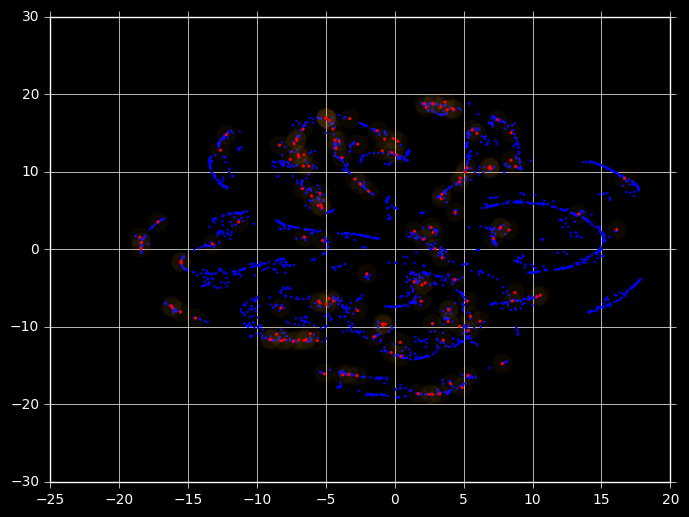

In [166]:
scatter_heat(sorted_data, len(d0), alpha=0.05)

In [192]:
reload(neural)
batch_size = 100
autoclasser = neural.SimpleAutoClasser(x_train.shape, batch_size=batch_size, latent_dim=8)
ae, enc, dec, classer = autoclasser.get_models()

DS shape: (6041, 16384)
('Batch Shape: ', (100, 16384))
Input Dims: 16384, input shape: (16384,), encoding dims: 8
('Sizes', [512, 44])


In [197]:
(x_train_, y_train_), (x_val2, y_val2) = dataio.subdiv_split_shuffle(x_train_z, y_train_z, validation_split=0.505)
x_train_.reshape(x_train_.shape[0], x_train_.shape[1], 1)
# y_train2 = np_utils.to_categorical(np.asarray(y_train2, dtype=int), nb_classes=2)
y_val2 = np_utils.to_categorical(np.asarray(y_val2, dtype=int), nb_classes=2)
print(x_train_.shape, y_train_.shape, x_val2.shape, y_val2.shape)

val_cut:  75
(2244, 16384) (2244, 1) (150, 16384) (150, 2)


In [194]:
ae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_19 (InputLayer)            (None, 16384)         0                                            
____________________________________________________________________________________________________
dense_64 (Dense)                 (None, 512)           8389120     input_19[0][0]                   
____________________________________________________________________________________________________
gaussiannoise_19 (GaussianNoise) (None, 512)           0           dense_64[0][0]                   
____________________________________________________________________________________________________
batchnormalization_13 (BatchNorma(None, 512)           1024        gaussiannoise_19[0][0]           
___________________________________________________________________________________________

In [195]:
ae.fit(x_train2, x_train2, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, x_val2))

Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [==============================] - 17s - loss: 1110.8803 - val_loss: -0.0174


In [152]:
# classer.fit(x_train2, y_train2, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, y_val2))

In [190]:
# CROSSTRAIN
nb_mega = 10
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    ae.fit(x_train2, x_train2, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, x_val2), shuffle=True)
    classer.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=2, validation_data=(x_val2, y_val2), shuffle=True)

Mega-epoch 0 of 10
Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [==============================] - 18s - loss: 251.4918 - val_loss: -0.7379
Train on 300 samples, validate on 150 samples
Epoch 1/2
300/300 [==============================] - 1s - loss: 5.8415 - acc: 0.4233 - val_loss: 0.7823 - val_acc: 0.4467
Epoch 2/2
300/300 [==============================] - 0s - loss: 5.8024 - acc: 0.5033 - val_loss: 0.7813 - val_acc: 0.4267
Mega-epoch 1 of 10
Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [==============================] - 18s - loss: 170.0264 - val_loss: -0.5009
Train on 300 samples, validate on 150 samples
Epoch 1/2
300/300 [==============================] - 0s - loss: 5.7713 - acc: 0.4600 - val_loss: 0.7793 - val_acc: 0.4400
Epoch 2/2
300/300 [==============================] - 0s - loss: 5.7636 - acc: 0.4467 - val_loss: 0.7838 - val_acc: 0.4800
Mega-epoch 2 of 10
Train on 2346 samples, validate on 150 samples
Epoch 1/1
2346/2346 [=========

In [199]:
# Train just the classer
nb_mega = 100
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    classer.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=1, validation_data=(x_val2, y_val2))

Mega-epoch 0 of 100
Train on 300 samples, validate on 150 samples
Epoch 1/1
300/300 [==============================] - 0s - loss: 5.6406 - acc: 0.6333 - val_loss: 0.8181 - val_acc: 0.4400
Mega-epoch 1 of 100
Train on 300 samples, validate on 150 samples
Epoch 1/1
300/300 [==============================] - 0s - loss: 5.6055 - acc: 0.6400 - val_loss: 0.8146 - val_acc: 0.4400
Mega-epoch 2 of 100
Train on 300 samples, validate on 150 samples
Epoch 1/1
300/300 [==============================] - 0s - loss: 5.6399 - acc: 0.6133 - val_loss: 0.8115 - val_acc: 0.4333
Mega-epoch 3 of 100
Train on 300 samples, validate on 150 samples
Epoch 1/1
300/300 [==============================] - 0s - loss: 5.6463 - acc: 0.6300 - val_loss: 0.8074 - val_acc: 0.4400
Mega-epoch 4 of 100
Train on 300 samples, validate on 150 samples
Epoch 1/1
300/300 [==============================] - 0s - loss: 5.6159 - acc: 0.6333 - val_loss: 0.8027 - val_acc: 0.4467
Mega-epoch 5 of 100
Train on 300 samples, validate on 150 sa

KeyboardInterrupt: 

#### Standard autoencoders - no convo, no VAE - kinda suck for classification/crossfire models. 

In [156]:
encoded0 = autoclasser.encoder.predict(d0_z)
encoded1 = autoclasser.encoder.predict(d1_z)

In [157]:
encoded0.shape

(2244, 4)

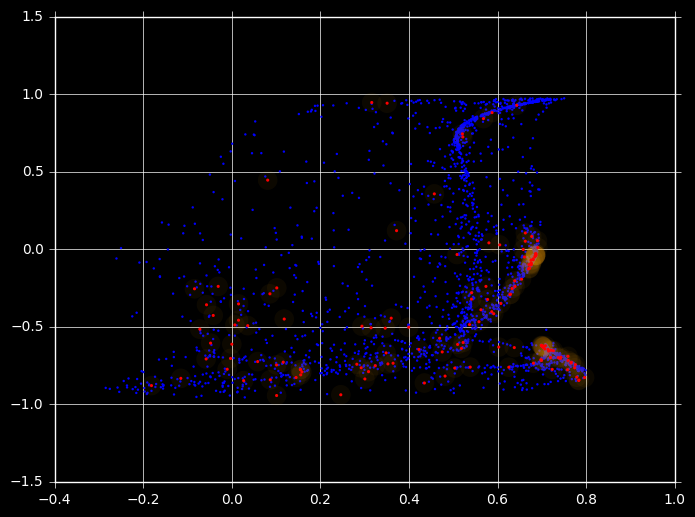

In [160]:
# plt.scatter(encoded0[:,0], encoded0[:,1])
# plt.scatter(encoded1[:,0], encoded1[:,1])
encoded = np.concatenate([encoded0, encoded1], axis=0)
scatter_heat(encoded[:,0:], len(d0_z), alpha=.05)

In [161]:
tsne = manifold.TSNE(random_state=1337)
sorted_data = tsne.fit_transform(encoded)

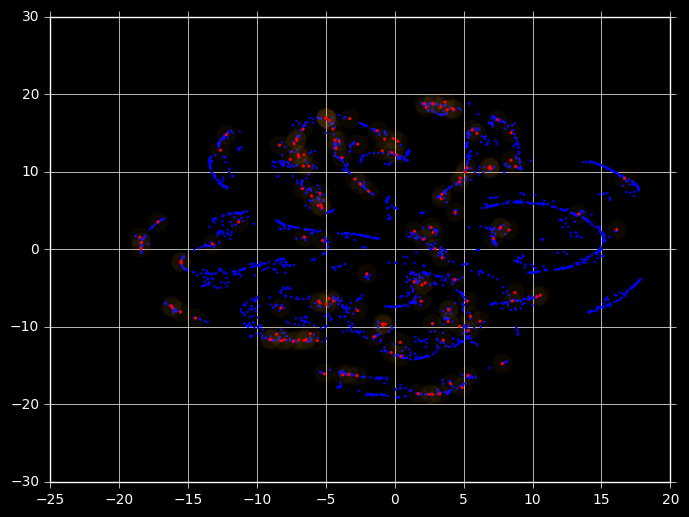

In [162]:
scatter_heat(sorted_data, len(d0_z), alpha=.05)

In [47]:
pred = classer.predict(x_guess_z)

In [48]:
np.mean(pred, axis=0)

array([ 0.51817632,  0.52593523], dtype=float32)

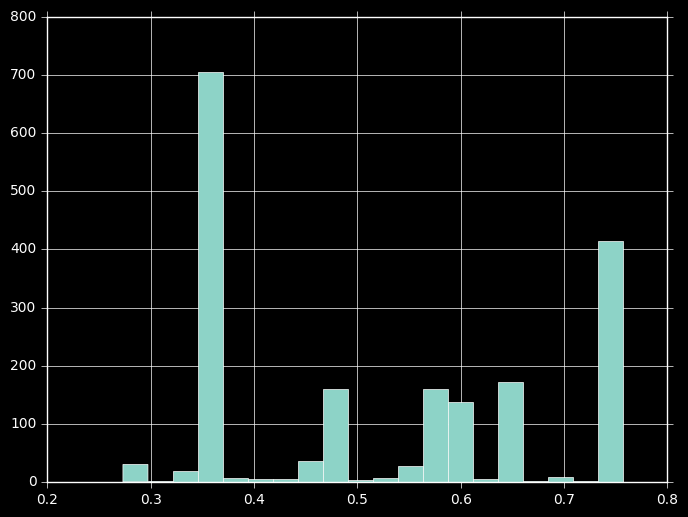

In [49]:
pd.Series(pred[:,0]).hist(bins=20)

In [50]:
pred_classes = pred > 0.5

In [51]:
np.mean(pred_classes, axis=0)

array([ 0.49056604,  0.28773585])

In [52]:
guess = pred_classes[:,0]

In [53]:
files2['Class'] = pd.Series(guess, dtype=int)
files2['File'] = pd.Series([os.path.basename(nm) for nm in files2['path']])

In [54]:
time_start = int(time.time())
time_str = str(time_start)[-7:-3] + '_' + str(time_start)[-3:]
files2.to_csv('./eegkaggle/guesses/new_AC_11_28_{}.csv'.format(time_str)) # fix this

In [ ]:
nb_hidden = 255 # number of hidden nodes
nb_classes = 2 # ten digits, so ten output nodes (one-hot)
nb_epoch = 3 # number of epochs. 1 epoch is training once on the entire set of training samples

input_dim = x_train.shape[1] # 28x28 = 784
model = Sequential()
model.add(Dense(nb_hidden, activation='linear', input_dim=input_dim))
model.add(GaussianNoise(0.2))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(.5))
model.add(Dense(output_dim=nb_hidden, activation='relu'))
model.add(Dense(output_dim=nb_classes, activation='sigmoid')) # Here we use sigmoid because we wanna force the output to 0-1

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
nb_mega = 20
for i in range(nb_mega):
    print('Mega-epoch {} of {}'.format(i, nb_mega))
    seed = i
    x_sub, y_sub = dataio.shuffle_split_with_label(x_train2, y_train2, seed=i)
    y_sub_cls = np_utils.to_categorical(np.asarray(y_sub, dtype=int), 2)
    model.fit(x_sub, y_sub_cls, batch_size=batch_size, nb_epoch=3, validation_data=(x_val2, y_val2))

In [46]:
pred_classes = model.predict_classes(x_val2) # Let the model automatically determine the classes

AttributeError: 'Model' object has no attribute 'predict_classes'

In [ ]:
pred_classes

In [ ]:
valacc = np.mean(pred_classes == y_val2[:,1]) # Final accuracy on validation batch
print('Validation Accuracy: {}'.format(valacc))

In [ ]:
plt.plot(np.mean(x_guess_z, axis=0))

In [ ]:
guess = model.predict_classes(x_guess_z)

In [ ]:
np.mean(guess, axis=0)

In [ ]:
files2['Class'] = pd.Series(guess, dtype=int)
files2['File'] = pd.Series([os.path.basename(nm) for nm in files2['path']])

In [ ]:
time_start = int(time.time())
time_str = str(time_start)[-7:-3] + '_' + str(time_start)[-3:]
files2.to_csv('./eegkaggle/guesses/new_cnn_11_27_{}.csv'.format(time_str)) # fix this